# Capstone Project - The Battle of the Neighborhoods in Warsaw
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Warsaw is the capital of Poland and the largest city in the country. The city's population is 1.8 million with a density of 3,469 people per square kilometer. Warsaw is divided into 18 districts with different population densities and areas. As a person who lived there for 5 years, I decided to choose this place for my project.

There are numerous companies and universities in the city attracting a huge number of interested people. Everyone is interested in various attractions in the city, depending on their needs. A family with children will have different needs than a student. The need to find an interesting and cheap point for yourself is a very important aspect. Additional needs are the knowledge of attractions available in the selected area.

Data on average housing prices will be presented on the map for individual districts. Additionally, we will have clustered information about venue density.

## Data <a name="data"></a>

Based on the definition of our problem, the factors that will influence our decision are:
* number of points of interest broken down by type;
* Average prices of apartments in the area.

The following sources will be used to obtain the necessary information:

* Wikipedia - Administrative divisions of Warsaw;
* Forsquare API to obtain information about the points of interest;
* Public data on average prices per square meter in individual districts.

### Neighborhood Candidates

Let's inmport all needed librariers for project.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import html5lib
import numpy as np # library to handle data in a vectorized manner
import csv


import json # library to handle JSON files

from geopy.geocoders import Nominatim
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import openpyxl
from pathlib import Path
print('Libraries imported.')

Libraries imported.


### Neighborhood Candidates

First, let's download the list of Warsaw districts from Wikipedia. These data will help us in the next steps of the analysis.

Wikipedia data was retrieved using the Python Beautiful Soup library. This library allows you to download data from websites for use in data analysis.

In [2]:
html_data=requests.get('https://pl.wikipedia.org/wiki/Warszawa').text

In [3]:
soup_data = BeautifulSoup(html_data, 'html5lib')

Retrieving data from a table on the page

In [4]:

table_contents = pd.DataFrame(columns=["Neighborhood", "Count_of_citizens", "Density_of_citizens", "Area"])

table=soup_data.find('table', class_='sortable') 

for row in table.find("tbody").find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        neighborhood = col[0].text
        count_of_citizens = col[1].text
        density_of_citizens = col[2].text.strip()
        area = col[3].text.strip()
        table_contents = table_contents.append({"Neighborhood":neighborhood, "Count_of_citizens":count_of_citizens, "Density_of_citizens":density_of_citizens, "Area":area}, ignore_index=True)
table_contents.head()

,Neighborhood,Count_of_citizens,Density_of_citizens,Area
0,Mokotów,218 265,6162,"35,42"
1,Praga-Południe,180 789,8078,"22,38"
2,Ursynów,151 304,3455,"43,79"
3,Wola,141 407,7342,"19,26"
4,Bielany,131 592,4069,"32,34"


Upload collected data about prices and coordinates for all neighborhoods in Warsaw.

In [5]:
data = pd.read_excel (r'C:\Users\siedleck\OneDrive - TomTom\Documents\GitHub\Capstone Project\Warsaw_Price.xlsx') 
data
df_price = pd.DataFrame(data, columns= ['Neighborhood', 'Price', 'Currency', 'Latitude', ' Longitude'])
df_price.head()

,Neighborhood,Price,Currency,Latitude,Longitude
0,Praga-Południe,9840,PLN,52.241663,21.080788
1,Bemowo,9593,PLN,52.240780,20.912336
2,Targówek,8874,PLN,52.282402,21.065551
3,Ursus,8824,PLN,52.194752,20.883897
4,Wawer,8740,PLN,52.195783,21.180152


Merge Data about neighberhoods

In [6]:
merged = pd.merge(table_contents, df_price, how="left", on="Neighborhood", validate="one_to_one")

merged.head()

,Neighborhood,Count_of_citizens,Density_of_citizens,Area,Price,Currency,Latitude,Longitude
0,Mokotów,218 265,6162,"35,42",11500,PLN,52.194494,21.031829
1,Praga-Południe,180 789,8078,"22,38",9840,PLN,52.241663,21.080788
2,Ursynów,151 304,3455,"43,79",10105,PLN,52.138363,21.032758
3,Wola,141 407,7342,"19,26",11830,PLN,52.233072,20.958001
4,Bielany,131 592,4069,"32,34",10014,PLN,52.293450,20.929596


Let's first find the latitude & longitude of Warsaw city center.

In [7]:
address = 'Warsaw'

geolocator = Nominatim(user_agent="WARSAW_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Warsaw  are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Warsaw  are 52.2319581, 21.0067249.


Map show us average prices per square meter in each Warsaw District.

In [8]:
# create map and display it
warsaw_map = folium.Map(location=[latitude, longitude], zoom_start=12)


for lat, lon, poi in zip(merged['Latitude'], merged[' Longitude'], merged['Price']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5, 
        color='yellow',
        fill=True,
        popup="Price per square meter {} PLN".format(poi),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(warsaw_map)
# show map
warsaw_map

The most expensive district is Śródmieście. Price per square meter is araound 14 536 PLN. Let's check how lool like density of venues in districts.

Collection of data from Forsquare API will give us information about density of venues.

In [9]:
CLIENT_ID = 'G0CEH0GJWA1NL5VQZ13AOLIQRBMXZOJYRZFIDSBER3NEUXFN' # your Foursquare ID
CLIENT_SECRET = 'D2FWGDNIJ441N25WKLZW221TP5MJGF4L14YOYNHHCZVGXJI3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G0CEH0GJWA1NL5VQZ13AOLIQRBMXZOJYRZFIDSBER3NEUXFN
CLIENT_SECRET:D2FWGDNIJ441N25WKLZW221TP5MJGF4L14YOYNHHCZVGXJI3


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# type your answer here
warsaw_venues = getNearbyVenues(names=merged['Neighborhood'],
                                   latitudes=merged['Latitude'],
                                   longitudes=merged[' Longitude']
                                  )

Mokotów
Praga-Południe
Ursynów
Wola
Bielany
Białołęka
Bemowo
Targówek
Śródmieście
Ochota
Wawer
Praga-Północ
Ursus
Żoliborz
Włochy
Wilanów
Wesoła
Rembertów


In [12]:
print(warsaw_venues.shape)
warsaw_venues.head()

(210, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mokotów,52.194494,21.031829,Centrum Futbolu Warszawianka,52.195873,21.028518,Soccer Field
1,Mokotów,52.194494,21.031829,Park Arkadia,52.190851,21.028433,Park
2,Mokotów,52.194494,21.031829,Warszawianka Korty,52.197041,21.030077,Tennis Court
3,Mokotów,52.194494,21.031829,W górę ścianka wspinaczkowa,52.196791,21.026085,Climbing Gym
4,Mokotów,52.194494,21.031829,Warszawianka Wodny Park,52.195035,21.025864,Gym Pool


Cleaning and gruping venues into category

In [13]:
# one hot encoding
warsaw_onehot = pd.get_dummies(warsaw_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
warsaw_onehot['Neighborhood'] = warsaw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [warsaw_onehot.columns[-1]] + list(warsaw_onehot.columns[:-1])
warsaw_onehot =warsaw_onehot[fixed_columns]

warsaw_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Argentinian Restaurant,Asian Restaurant,Automotive Shop,Bakery,Bar,Beer Bar,Big Box Store,...,Theme Park Ride / Attraction,Train,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Wine Bar,Yoga Studio
0,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mokotów,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
warsaw_grouped = warsaw_onehot.groupby('Neighborhood').mean().reset_index()
warsaw_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Argentinian Restaurant,Asian Restaurant,Automotive Shop,Bakery,Bar,Beer Bar,Big Box Store,...,Theme Park Ride / Attraction,Train,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Wine Bar,Yoga Studio
0,Bemowo,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
1,Bielany,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
2,Mokotów,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0
3,Ochota,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0625,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.0,0.0
4,Praga-Południe,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0


In [15]:
num_top_venues = 5

for hood in warsaw_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = warsaw_grouped[warsaw_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bemowo----
                 venue  freq
0          Bus Station  0.11
1    Food & Drink Shop  0.11
2                Diner  0.06
3       Ice Cream Shop  0.06
4  Japanese Restaurant  0.06


----Bielany----
              venue  freq
0       Pizza Place  0.25
1  Doner Restaurant  0.12
2        Shoe Store  0.12
3     Grocery Store  0.12
4       Coffee Shop  0.12


----Mokotów----
          venue  freq
0          Park  0.13
1      Gym Pool  0.13
2  Tennis Court  0.07
3   Sports Club  0.07
4    Restaurant  0.07


----Ochota----
               venue  freq
0              Hotel  0.12
1  Electronics Store  0.06
2       Dessert Shop  0.06
3               Park  0.06
4       Tennis Court  0.06


----Praga-Południe----
                venue  freq
0         Coffee Shop  0.14
1              Hostel  0.07
2                Café  0.07
3  Italian Restaurant  0.07
4    Kebab Restaurant  0.07


----Praga-Północ----
               venue  freq
0  Convenience Store  0.14
1        Comedy Club  0.14
2          

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = warsaw_grouped['Neighborhood']

for ind in np.arange(warsaw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(warsaw_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bemowo,Bus Station,Food & Drink Shop,Diner,Ice Cream Shop,Japanese Restaurant,Furniture / Home Store,Park,Pet Store,Pizza Place,Donut Shop
1,Bielany,Pizza Place,Doner Restaurant,Shoe Store,Grocery Store,Coffee Shop,Bike Rental / Bike Share,Bus Station,Paintball Field,Ramen Restaurant,Pub
2,Mokotów,Park,Gym Pool,Tennis Court,Sports Club,Restaurant,Gym / Fitness Center,Gym,Gun Range,Paintball Field,Climbing Gym
3,Ochota,Hotel,Electronics Store,Dessert Shop,Park,Tennis Court,Pub,Bus Station,Flea Market,Department Store,Supermarket
4,Praga-Południe,Coffee Shop,Hostel,Café,Italian Restaurant,Kebab Restaurant,Fast Food Restaurant,Eastern European Restaurant,Restaurant,Clothing Store,Supermarket


In [19]:
warsaw_grouped_clustering = warsaw_grouped.drop('Neighborhood', 1)

In [20]:
 kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
 }

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(warsaw_grouped_clustering)
    sse.append(kmeans.inertia_)

In [21]:
import matplotlib.pyplot as plt

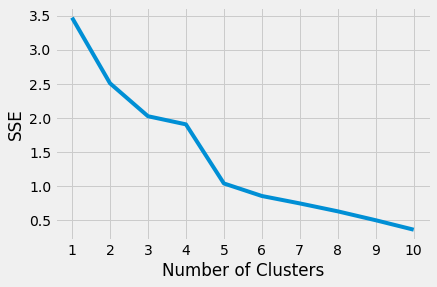

In [22]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Using the elbow method, I chose the number k = 5.

In [23]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(warsaw_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 1])

Merging data about prices with venues information

In [24]:

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

warsaw_merged = merged

warsaw_merged = warsaw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
warsaw_merged

,Neighborhood,Count_of_citizens,Density_of_citizens,Area,Price,Currency,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mokotów,218 265,6162,"35,42",11500,PLN,52.194494,21.031829,0.0,Park,Gym Pool,Tennis Court,Sports Club,Restaurant,Gym / Fitness Center,Gym,Gun Range,Paintball Field,Climbing Gym
1,Praga-Południe,180 789,8078,"22,38",9840,PLN,52.241663,21.080788,0.0,Coffee Shop,Hostel,Café,Italian Restaurant,Kebab Restaurant,Fast Food Restaurant,Eastern European Restaurant,Restaurant,Clothing Store,Supermarket
2,Ursynów,151 304,3455,"43,79",10105,PLN,52.138363,21.032758,1.0,Park,Accessories Store,American Restaurant,Pub,Polish Restaurant,Plaza,Playground,Pizza Place,Pharmacy,Pet Store
3,Wola,141 407,7342,"19,26",11830,PLN,52.233072,20.958001,0.0,Café,Bus Station,Rock Club,Gastropub,Gym / Fitness Center,Tram Station,Grocery Store,Sushi Restaurant,Theme Park Ride / Attraction,Noodle House
4,Bielany,131 592,4069,"32,34",10014,PLN,52.293450,20.929596,0.0,Pizza Place,Doner Restaurant,Shoe Store,Grocery Store,Coffee Shop,Bike Rental / Bike Share,Bus Station,Paintball Field,Ramen Restaurant,Pub
5,Białołęka,129 106,1768,"73,04",8211,PLN,52.329250,21.011960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Bemowo,125 119,5015,"24,95",9593,PLN,52.240780,20.912336,0.0,Bus Station,Food & Drink Shop,Diner,Ice Cream Shop,Japanese Restaurant,Furniture / Home Store,Park,Pet Store,Pizza Place,Donut Shop
7,Targówek,124 992,5161,"24,22",8874,PLN,52.282402,21.065551,0.0,Liquor Store,Hotel,Dessert Shop,Convenience Store,Eastern European Restaurant,Pizza Place,Farmers Market,Bus Station,Accessories Store,Park
8,Śródmieście,113 713,7303,"15,57",14536,PLN,52.223614,21.011722,0.0,Café,Vegetarian / Vegan Restaurant,Bakery,Coffee Shop,Plaza,Wine Bar,Bar,Cocktail Bar,Sushi Restaurant,Mexican Restaurant
9,Ochota,82 484,8486,"9,72",11396,PLN,52.210677,20.970061,0.0,Hotel,Electronics Store,Dessert Shop,Park,Tennis Court,Pub,Bus Station,Flea Market,Department Store,Supermarket


Cleaning data without venues.

In [25]:
warsaw=warsaw_merged.drop([5])
warsaw=warsaw.drop([15])

Drawing map with colored clustered venues

In [26]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(warsaw['Latitude'], warsaw[' Longitude'], warsaw['Neighborhood'], warsaw['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
         [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Methodology <a name="methodology"></a>

The aim of the analysis is to find the optimal district for the resident in accordance with his needs.
The first analyzed case is a family with children, and the second is a student.
As we all know, both families with children and students will be guided, among other things, by the price and attractions available nearby.

In the section on data, we have gathered the necessary information to make a decision. Data on home prices come from the Sonarhome.pl website, which collects data on prices.

Data on available attractions in each district was downloaded from the Forsquare API website.

GeoJson file with Warsaw district  was downloaded from git repository and edited to fit data from Wikipedia.

## Analysis <a name="analysis"></a>

Let's check the Top 10 venues per district

In [23]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Bemowo,Bus Station,Food & Drink Shop,Diner,Ice Cream Shop,Japanese Restaurant,Furniture / Home Store,Park,Pet Store,Pizza Place,Donut Shop
1,1,Bielany,Pizza Place,Doner Restaurant,Shoe Store,Grocery Store,Coffee Shop,Bike Rental / Bike Share,Bus Station,Paintball Field,Ramen Restaurant,Pub
2,1,Mokotów,Park,Gym Pool,Tennis Court,Sports Club,Restaurant,Gym / Fitness Center,Gym,Gun Range,Paintball Field,Climbing Gym
3,1,Ochota,Hotel,Electronics Store,Dessert Shop,Park,Tennis Court,Pub,Bus Station,Flea Market,Department Store,Supermarket
4,1,Praga-Południe,Coffee Shop,Hostel,Café,Italian Restaurant,Kebab Restaurant,Fast Food Restaurant,Eastern European Restaurant,Restaurant,Clothing Store,Supermarket
5,1,Praga-Północ,Convenience Store,Comedy Club,Drugstore,Market,Plaza,Pizza Place,Pharmacy,Accessories Store,Paintball Field,Pub
6,2,Rembertów,Chinese Restaurant,Accessories Store,Restaurant,Pub,Polish Restaurant,Plaza,Playground,Pizza Place,Pharmacy,Pet Store
7,1,Targówek,Liquor Store,Hotel,Dessert Shop,Convenience Store,Eastern European Restaurant,Pizza Place,Farmers Market,Bus Station,Accessories Store,Park
8,1,Ursus,Hotel,Ice Cream Shop,Pizza Place,Train Station,Train,Park,Supermarket,Middle Eastern Restaurant,Plaza,Playground
9,3,Ursynów,Park,Accessories Store,American Restaurant,Pub,Polish Restaurant,Plaza,Playground,Pizza Place,Pharmacy,Pet Store


In [27]:
print('There are {} uniques categories.'.format(len(warsaw_venues['Venue Category'].unique())))

There are 104 uniques categories.


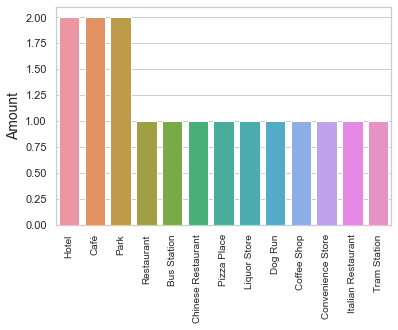

In [48]:
datas = pd.DataFrame({ 'Amount': neighborhoods_venues_sorted['1st Most Common Venue'].value_counts()})
datas

bar = sns.barplot(x=datas.index, y=datas.Amount )
bar.set_ylabel('Amount', fontsize=14)
bar.set_xticklabels(datas.index, fontsize=10, rotation=90);


There are 104 unique types of service categories in Warsaw. When analyzing the Top 1 for individual districts, we can see a large differentiation. The dominant types are cafe, hotel and park.

Let's check choropleth map to review prices for flats.

In [27]:
   
warsaw_boroughs_url = 'https://raw.githubusercontent.com/MagdalenaSiedlecka/Capstone-Project/main/warsaw.geojson'
warsaw_boroughs = requests.get(warsaw_boroughs_url).json()


In [28]:
warsaw_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [29]:
warsaw_map.choropleth(
    geo_data=warsaw_boroughs,
    data=merged,
    columns=['Neighborhood', 'Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price per m2'
)

for lat, lon, poi, Neighborhood  in zip(merged['Latitude'], merged[' Longitude'], merged['Price'], merged['Neighborhood']):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5, 
        color='yellow',
        fill=True,
        popup="Price per square meter {} PLN in {}".format(poi, Neighborhood),
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(warsaw_map)

# display map
warsaw_map

c:\users\siedleck\appdata\local\programs\python\python38-32\lib\site-packages\folium\folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


## Results and Discussion <a name="results"></a>

As mentioned at the beginning of the analysis, Warsaw is a large multicultural city. People come to Warsaw to start their adventure with a big city, studies or a better job. Analyzes like this can help them choose the right place to buy a home when they don't know the area.

As you can see on the last map, the highest prices are in the city center. This is due to the proximity of the subway, train station and the city's highest concentration of attractions. Well-connected neighborhoods will always be the most expensive.

When selecting the ka number during clustering, I was guided by the elbow method. The selected number of clusters is 5. 16 out of 18 districts of Warsaw were used in the analysis, as there was no data available in the Forsquare API for two of them.

## Conclusion <a name="conclusion"></a>

Such an analysis may be useful for visitors to choose the optimal location for their new apartment, taking into account its price and the surrounding area.

Future investors can use such data to spot the gap for their business, and city managers can better manage it.

Spatial analyzes can be used in everyday life by each of us, especially when we do not know the city.





Magdalena Siedlecka